In [1]:
%matplotlib notebook
%matplotlib inline

import os
from packaging import version
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})


# Below plots are based on Tensorboard logs (not based on every iteration)

## Uncomment this in case csv files are not available

In [2]:
# experiment_id, experiment_name = "6yl48QRjSySDUpTg8TpeRw", "st_uc-bg_bigBugfixMetric_bs4_split_1_1_trial1_29d20f8"
# experiment_id, experiment_name = "zNo4qyA5RBybC9m0sPRiZw", "st_uc-bg_bigBugfixMetric_bs4_split_1_1_trial1_b4f39ae"
# experiment_id, experiment_name = "7M4Qi6dmQteoRpuOibFbWQ", "st_fg_uc_bg_pl_o_95_85_85_s_0_26729b3"
# experiment_id, experiment_name = "xsV7RvysQkyiriyOKoTJ6A", "iou_metrics_st_bs8_split_1_1_trial_1_ca74a38"
# experiment_id, experiment_name = "o7fRMElwRAKv6boGQb29FQ", "rev-uc-bg_bs8_split_1_1_trial_1_293070a"


# experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
# df = experiment.get_scalars()
# df.to_csv(f"metrics_{experiment_name}.csv", index=False)

# df = pd.read_csv(f"metrics_{experiment_name}.csv")

## (Fig 6) Plot TP/FP/FN weights 

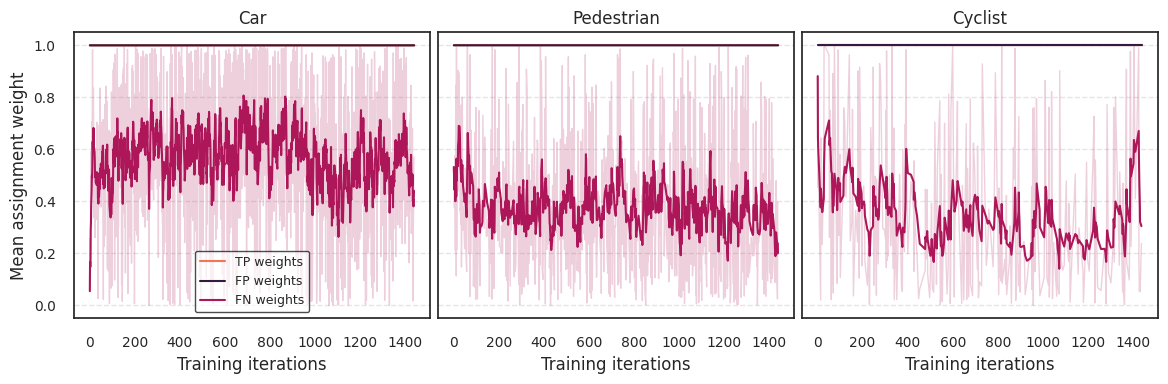

In [17]:
def draw_tp_fp_fn_weight_plot(df, fname, tags=None, tag_names=None, threshs=None, y_label=None):
    f, axes = plt.subplots(1, 3, sharey=True, figsize=(12,4))
    base_run = "tensorboard"
    classes = ["Car", "Pedestrian", "Cyclist"]
    p = sns.color_palette('rocket')
    palette = [p[-2], p[0], p[2]]
    for j, cls in enumerate(classes):
        for k, (tag, tname) in enumerate(zip(tags, tag_names)):
            run = base_run + "/" + tag + "/" + cls
            steps = df[df.run == run].step
            values = df[df.run == run].value
            smooth_values = df[df.run == run].ewm(alpha=0.2).mean().value
            
            # plot raw values with transperancy 
            sns.lineplot(ax=axes[j], x=steps, y=values, alpha=0.2, color=palette[k], lw=1)
            
            # plot smooth values
            if j == 0:
                sns.lineplot(ax=axes[j], x=steps, y=smooth_values, label=tname, color=palette[k], lw=1.5)
                axes[j].set_ylabel(y_label)
            else:
                sns.lineplot(ax=axes[j], x=steps, y=smooth_values, color=palette[k], lw=1.5)

        if j==0:
            axes[j].yaxis.set_tick_params(labelleft=True, labelsize="small")
        axes[j].set_xlabel("Training iterations")
        axes[j].xaxis.set_tick_params(labelsize="small")
        axes[j].set_title(cls)
        axes[j].yaxis.grid(True, linestyle='--', alpha=0.5)

    legend = axes[0].legend(frameon = True, fontsize=9, framealpha = 0.7)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')

    f.tight_layout()
    f.subplots_adjust(wspace=0.02, hspace=0.02)
    f.savefig(fname=fname, transparent=False, bbox_inches='tight')
    plt.show()

# --------------- TP/FP/FN weights ---------------
# exp_id_ab1_ours, exp_name_ab1_ours = "xsV7RvysQkyiriyOKoTJ6A", "iou_metrics_st_bs8_split_1_1_trial_1_ca74a38"
exp_id_ab1_ours, exp_name_ab1_ours = "o7fRMElwRAKv6boGQb29FQ", "rev-uc-bg_bs8_split_1_1_trial_1_293070a"
df_ab1_ours = pd.read_csv(f"metrics_{exp_name_ab1_ours}.csv")

tags = ["rcnn_roi_pl_gt_metrics_cls/pred_weight_tp", "rcnn_roi_pl_gt_metrics_cls/pred_weight_fp", "rcnn_roi_pl_gt_metrics_cls/pred_weight_fn"]
tag_names = ["TP weights", "FP weights", "FN weights"]
y_label = "Mean assignment weight"
draw_tp_fp_fn_weight_plot(df_ab1_ours, fname=f"pred_weights_tp_fp_fn.png", tags=tags, y_label=y_label, tag_names=tag_names)

## (Fig 7) FG/BG ratio 

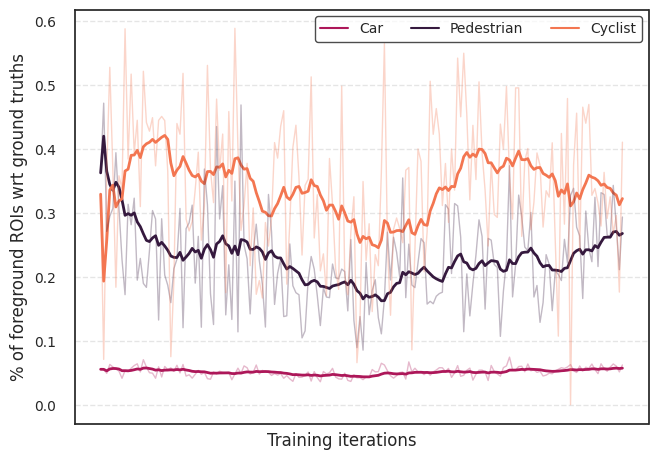

In [14]:
p = sns.color_palette('rocket')
def draw_metrics_num_fg(df, fname, tags=None, y_label=None, colors=None):
    f, axes = plt.subplots(1, 1, sharey=True, figsize=(6.5,4.5))
    base_run = "tensorboard"
    classes = ["Car", "Pedestrian", "Cyclist"]
    if colors is None : 
        colors = sns.color_palette('rocket', len(classes))
        palette = {'Car': p[2], 'Pedestrian':p[0], 'Cyclist': p[-2]}

    classwise_df=pd.DataFrame()
    org_classwise_df = pd.DataFrame()
    for cls_idx, (cls, color) in enumerate(zip(classes, colors)):
        run = base_run + "/" + tags + "/" + cls
        steps = df[df.run == run].step
        values = df[df.run == run].value
        smooth_values = df[df.run == run].ewm(alpha=0.1).mean().value
        # store all classwise IoUs in a single dataframe and plot all at once
        classwise_df[cls] = smooth_values.reset_index(drop=True)
        org_classwise_df[cls] = values.reset_index(drop=True)
            
    sns.lineplot(ax=axes, data=classwise_df, linewidth=2, dashes=False, legend = True, palette=palette)
    sns.lineplot(ax=axes, data=org_classwise_df, linewidth=1, dashes=False, legend = False, palette=palette, alpha = 0.3)

    # x/y ticks
    axes.yaxis.set_tick_params(labelleft=True, labelsize='small')
    axes.xaxis.set_tick_params(labelbottom=False)
    axes.yaxis.grid(True, linestyle='--', alpha=0.5)

    legend = axes.legend(frameon = True, fontsize=10, ncol=3, framealpha = 0.7)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')

    # common plot labels
    f.text(0.5, -0.01, "Training iterations", ha='center')
    f.text(-0.01, 0.5, y_label, va='center', rotation='vertical')
    f.tight_layout()
    f.subplots_adjust(wspace=0.02, hspace=0.05)
    f.savefig(fname=fname, transparent=False, bbox_inches='tight')
    plt.show()

####################################################################
# Plot setting and theme
plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})

# --------------- Ablation 1 ---------------
exp_id_ab1_ours, exp_name_ab1_ours = "f5nMZ6K9SySkIYEEP1J2jw", "st_fg_uc_bg_pl_o_95_85_85_s_0_26729b3"
df_ab1_ours = pd.read_csv(f"metrics_{exp_name_ab1_ours}.csv")

# --------------- Raw IoUs based on FG ---------------
tag = "rcnn_roi_pl_gt_metrics_cls/pred_fgs"
y_label = '% of foreground ROIs wrt ground truths'
fname = f"pred_fgs.pdf"

draw_metrics_num_fg(df=df_ab1_ours, fname=fname, tags=tag, y_label=y_label)

# Below plots are based on .pkl files as they are plotted based on each iteration

In [5]:
import pandas as pd
import numpy as np
import torch
from matplotlib.colors import ListedColormap
plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})

cmap = sns.color_palette("rocket_r", as_cmap=True)
_cmap = sns.color_palette("rocket", as_cmap=True)

df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/best_st_scores.pkl') # best_st_plot_60c84b7
baseline_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_baseline.pkl') # iou_metrics_baseline_bs8_split_1_1_trial_1_d16ba20
# This is based on FG+UC+BG with class agnostic local thresholds , it needs a re-run to get the correct class agnostic scores based on UC_FP+BG
ablation1_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_ablation1.pkl') 
df.keys()

dict_keys(['iou_roi_pl', 'iou_roi_gt', 'pred_scores', 'weights', 'class_labels', 'iteration'])

## (Fig 1) Need of classwise thresholds

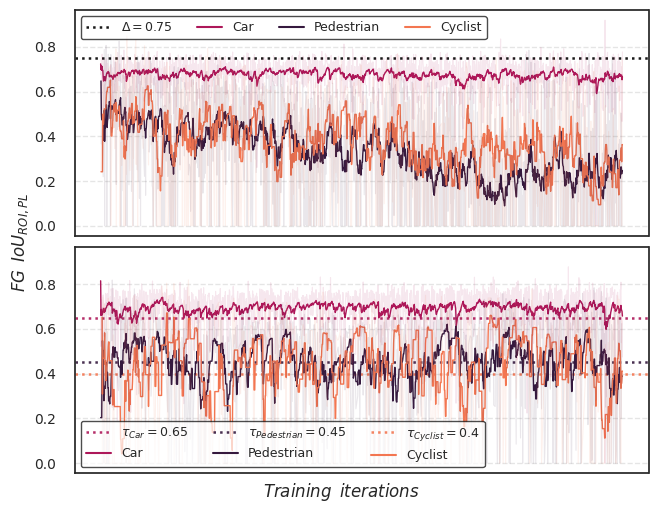

In [20]:
def get_fg_iou_plot(dfs):
    sns.set_theme(style="ticks", palette="rocket_r", rc={
                                                        'xtick.bottom': False,
                                                        'ytick.left': False,
                                                        })      
    f, axes = plt.subplots(2, 1, sharey=True, figsize=(6.5,5))
    thresh = [[0.75,0.75,0.75], [0.65,0.45,0.4]] # local thresholds 
    fg_thresh = [0.7, 0.5, 0.5] # for getting FG mask 
    num_to_class = {1:'Car', 2:'Pedestrian', 3:'Cyclist'}
    
    p = sns.color_palette('rocket')
    colors = sns.color_palette('rocket', len(thresh))
    palette = {'Car': p[2], 'Pedestrian':p[0], 'Cyclist': p[-2]}

    for j in range(2):
        df = dfs[j]

        fg_iou_roi_pl_df = pd.DataFrame({'iteration': np.arange(0,1440)})
        fg_iou_roi_pl_df['Car'] = np.nan
        fg_iou_roi_pl_df['Pedestrian'] = np.nan
        fg_iou_roi_pl_df['Cyclist'] = np.nan

        for cls_idx, cls_name in num_to_class.items():
            cls_mask = torch.Tensor(df['class_labels'])==cls_idx
            fg_mask = torch.Tensor(df['iou_roi_gt']) >= fg_thresh[cls_idx-1]
            valid_mask = cls_mask & fg_mask

            aux_df = pd.DataFrame()
            aux_df['iou_roi_pl'] = torch.Tensor(df['iou_roi_pl'])[valid_mask]
            aux_df['iteration'] = torch.Tensor(df['iteration'])[valid_mask]
            fg_iou_roi_pl = aux_df.groupby('iteration')['iou_roi_pl'].mean().reset_index()
            # print(fg_iou_roi_pl)
            for idx, _ in fg_iou_roi_pl_df.iterrows():
                if fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].size != 0:
                    fg_iou_roi_pl_df.at[idx, cls_name] = fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].values[0]

            # plot threshold lines 
            if j == 0 and cls_idx == 1:
                axes[j].axhline(y=thresh[j][cls_idx-1], linestyle=":", label="$\\Delta=0.75$", color='black', alpha=0.9, lw=1.8)
            if j == 1:
                label = "$\\tau_{cls}=thresh$".replace('cls', cls_name).replace('thresh', str(thresh[j][cls_idx-1]))
                axes[j].axhline(y=thresh[j][cls_idx-1], linestyle=":", label=label, color=palette[cls_name], alpha=0.9, lw=1.8)
            axes[j].yaxis.set_tick_params(labelleft=True)
    
        # plot ious
        fg_iou_roi_pl_df = fg_iou_roi_pl_df.drop(['iteration'], axis=1)
        sns.lineplot(ax=axes[j], data=fg_iou_roi_pl_df.ewm(alpha=0.1).mean(), linewidth=1, dashes=False, legend = True, palette=palette)
        sns.lineplot(ax=axes[j], data=fg_iou_roi_pl_df, linewidth=0.8, dashes=False, legend = False, palette=palette, alpha = 0.1)

        # x/y ticks
        # axes[j].set_yticks(np.arange(0.15, 0.8, 0.15))
        axes[j].yaxis.set_tick_params(labelleft=True, labelsize='small')
        axes[j].xaxis.set_tick_params(labelbottom=False)
        axes[j].yaxis.grid(True, linestyle='--', alpha=0.5)
        # legends
        handles, labels = axes[j].get_legend_handles_labels()

        order = [0,3,1,4,2,5] if j == 1 else [0,1,2,3]
        ncol = 3 if j==1 else 4
        if j==0:
            legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
                                    frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7, loc="upper left")
        else:
            legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
                                    frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7, loc="lower left")
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')
    
    # common plot labels
    f.text(0.5, -0.01, "$Training\enspaceiterations$", ha='center')
    f.text(-0.01, 0.5, '$FG\enspaceIoU_{ROI, PL}$', va='center', rotation='vertical')
    f.tight_layout()
    f.subplots_adjust(wspace=0.02, hspace=0.05)
    f.savefig(fname=f"fg_roi_iou_wrt_pl_ab1.pdf", transparent=False, bbox_inches='tight')
    plt.show()

#! TODO : change baseline dataframe to ablation 1 dataframe !!
dfs = [ablation1_df, df]
get_fg_iou_plot(dfs)

##  (Fig 4) % of FG IoUs crossing local thresh using Barplot

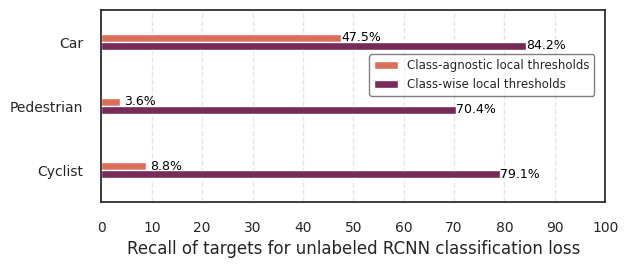

In [11]:
def get_fg_iou_barplot(dfs):
    sns.set_theme(style="ticks", palette="rocket_r", rc={
                                                        'xtick.bottom': False,
                                                        'ytick.left': False,
                                                        })      
    f, axes = plt.subplots(1, 1, sharey=True, figsize=(6.5,2.5))
    thresh = [[0.75,0.75,0.75], [0.65,0.45,0.4]] # local thresholds 
    fg_thresh = [0.7, 0.5, 0.5] # for getting FG mask 
    num_to_class = {1:'Car', 2:'Pedestrian', 3:'Cyclist'}
    
    p = sns.color_palette('rocket')
    colors = sns.color_palette('rocket', len(thresh))
    palette = {'Car': p[2], 'Pedestrian':p[0], 'Cyclist': p[-2]}
    combined_df = pd.DataFrame()
    for j in range(2):
        experiment = 'Class-agnostic local thresholds' if j==0 else 'Class-wise local thresholds'
        df = dfs[j]
        
        aux_df = pd.DataFrame()
        aux_df['iou_roi_pl'] = torch.Tensor(df['iou_roi_pl'])
        aux_df['iou_roi_gt'] = torch.Tensor(df['iou_roi_gt'])
        aux_df['iteration'] = torch.Tensor(df['iteration'])
        aux_df['class_labels'] = torch.Tensor(df['class_labels'])

        condition1 = (aux_df['class_labels']==1) & (aux_df['iou_roi_gt']<0.7)
        condition2 = (aux_df['class_labels']==2) & (aux_df['iou_roi_gt']<0.5)
        condition3 = (aux_df['class_labels']==3) & (aux_df['iou_roi_gt']<0.5)
        fg_df = aux_df.drop(aux_df[condition1 | condition2 | condition3].index)

        classwise_dict = {'Car': None, 'Pedestrian': None, 'Cyclist': None}
        fg_percent = {}
        for cls_idx, cls_name in enumerate(num_to_class.values()):
            classwise_df = pd.DataFrame()
            classwise_df = fg_df[fg_df['class_labels']==(cls_idx+1)]
            classwise_dict[cls_name] = classwise_df
            fg_percent[cls_name] = len(classwise_df[classwise_df['iou_roi_pl'] > thresh[j][cls_idx]]) / len(classwise_df)
            combined_df = combined_df.append({'Experiment': experiment, 'class_labels': cls_name, 'fg_percent': fg_percent[cls_name]}, ignore_index=True)

    ax = sns.barplot(data=combined_df, x="fg_percent", y="class_labels", hue="Experiment", palette="rocket_r", width=0.25, orient="h")
    ax.set(xlabel="Recall of targets for unlabeled RCNN classification loss", ylabel=None)
    patches = ax.patches
    for i in range(len(patches)):
        x = patches[i].get_width() + 0.04
        y = patches[i].get_y() + patches[i].get_height()/2 + 0.05
        ax.annotate('{:.1f}%'.format(list(combined_df['fg_percent']*100)[i]), (x, y), ha='center', color="black", size=9)

    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_xticklabels(np.arange(0, 110, 10))
    ax.yaxis.set_tick_params(labelleft=True, labelsize='small')
    ax.xaxis.set_tick_params(labelbottom=True, labelsize='small')
    ax.xaxis.grid(True, linestyle='--', alpha=0.5)
    legend = ax.legend(frameon = True, ncol=1, fontsize=8.5, framealpha = 0.5, loc='best', bbox_to_anchor=(0.99, 0.8))
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')
    plt.show()
    
    f.tight_layout()
    f.savefig(fname=f"cls_target_recall.pdf", transparent=False, bbox_inches='tight')

dfs = [ablation1_df, df]
get_fg_iou_barplot(dfs)


## (Fig 5) Weights scatterplot 

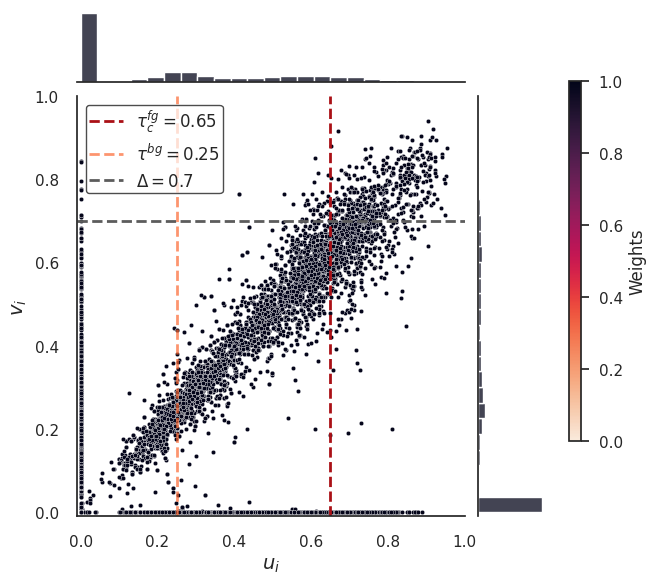

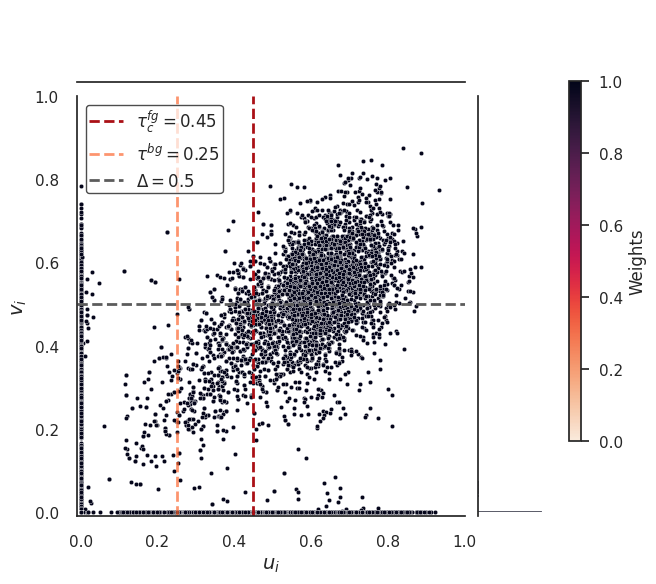

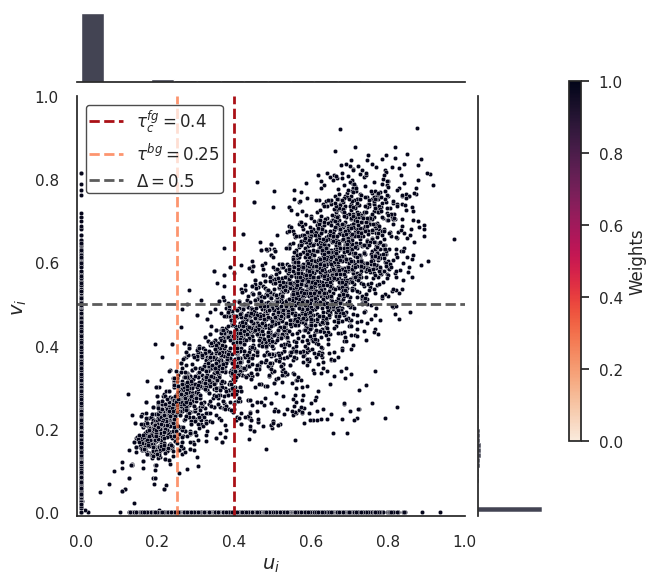

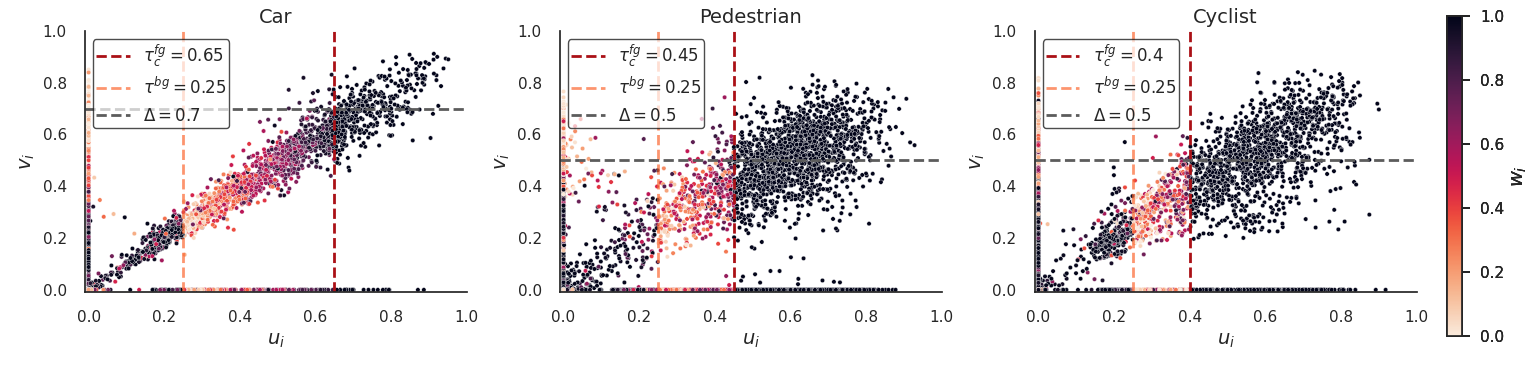

In [19]:
import matplotlib.gridspec as gridspec

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec, class_name, disable_marginal_plot=True):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        self.disable_marginal_plot = disable_marginal_plot
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid(class_name)
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self, class_name):
        """ Move Jointgrid """
        self.sg.ax_joint.set_title(class_name, fontsize=14)
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        # disable marginal plots 
        if not self.disable_marginal_plot:
            self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
            self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])
        
        left_pos = 0.97 if self.disable_marginal_plot else 1
        # Make space for the colorbar
        self.fig.subplots_adjust(right=1.2)
        # Define a new Axes where the colorbar will go
        cax = self.fig.add_axes([left_pos, 0.1, .01, 0.80])
        # Get a mappable object with the same colormap as the data
        points = plt.scatter([], [], c=[], vmin=0, vmax=1, cmap=cmap)
        # Draw the colorbar
        self.fig.colorbar(points, cax=cax).set_label("$w_{i}$", fontsize=14)

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())


def get_joint_plot(df, class_name, fig_title="Default", plot_type="joint", epoch_num=10):
    class_to_num = {'Car': 1, 'Pedestrian': 2, 'Cyclist': 3}
    pl_thresh = {'FG':{'Car': 0.65, 'Pedestrian': 0.45, 'Cyclist': 0.40}, 'BG': 0.25}
    gt_thresh = {'FG':{'Car': 0.70, 'Pedestrian': 0.50, 'Cyclist': 0.50}, 'BG': 0.25}

    class_num = class_to_num[class_name]
    class_mask = (torch.Tensor(df['class_labels'])).int() == class_num
    start_iter = 1439-(24*epoch_num)

    epoch_mask = torch.Tensor(df['iteration']).int() > start_iter
    ignore_bg_mask = ~((torch.Tensor(df['iou_roi_pl']) < pl_thresh['BG']) & (torch.Tensor(df['iou_roi_gt']) < pl_thresh['BG']))
    valid_mask = class_mask & epoch_mask #& ignore_bg_mask

    valid_df = pd.DataFrame({'iou_roi_pl': torch.Tensor(df['iou_roi_pl'])[valid_mask], 
                            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
                            'weights': torch.Tensor(df['weights'])[valid_mask],
                            'pred_scores': torch.Tensor(df['pred_scores'])[valid_mask],
                            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]})
    valid_df['class_labels'] = valid_df['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})

    if plot_type=='kde':
        g = sns.kdeplot(x=valid_df.iou_roi_pl, y=valid_df.iou_roi_gt, cmap=cmap, palette="rocket_r", shade=True, bw_adjust=.5)
        plt.show()
    else:
        if fig_title=='Before':
            color = _cmap(1)
            g = sns.jointplot(data=valid_df, x="iou_roi_pl", y="iou_roi_gt", color=color, xlim=-0.01, ylim=-0.01, legend=True, palette="rocket_r", s=10)
        else:
            g = sns.jointplot(data=valid_df, x="iou_roi_pl", y="iou_roi_gt", hue='weights', xlim=-0.01, ylim=-0.01, legend=False, palette="rocket_r", s=10)
        g.set_axis_labels('$u_{i}$', '$v_{i}$', fontsize=14)
    
        plt.axvline(x=pl_thresh['FG'][class_name], ymin=0, ymax=1, linestyle='--', color=sns.color_palette("Reds")[-1], label="$\\tau^{fg}_{c}=var$".replace('var', str(pl_thresh['FG'][class_name])), lw=2)
        plt.axvline(x=pl_thresh['BG'], ymin=0, ymax=1, linestyle='--', color=sns.color_palette('YlOrRd')[-3], label="$\\tau^{bg}=var$".replace('var', str(pl_thresh['BG'])), alpha = 0.7, lw=2)
        plt.axhline(y=gt_thresh['FG'][class_name], xmin=0, xmax=1, linestyle='--', color=sns.color_palette("Greys")[-2], label="$\\Delta=var$".replace('var', str(gt_thresh['FG'][class_name])), lw=2)
        # plt.axhline(y=gt_thresh['BG'], xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau_{bg}=var$".replace('var', str(gt_thresh['BG'])), alpha = 0.7, lw=2)

        legend = plt.legend(bbox_to_anchor=(0.2, 1), frameon=True, fontsize=12, loc='upper center', borderpad=0.2, framealpha = 0.7) #'lower left'
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')

        # Make space for the colorbar
        g.fig.subplots_adjust(right=.92)
        # Define a new Axes where the colorbar will go
        cax = g.fig.add_axes([.96, .25, .02, .6])
        # Get a mappable object with the same colormap as the data
        points = plt.scatter([], [], c=[], vmin=0, vmax=1, cmap=cmap)
        # Draw the colorbar
        g.fig.colorbar(points, cax=cax).set_label("Weights")
        # plt.show()
    return g

car_plot_before = get_joint_plot(baseline_df, 'Car', "Before", epoch_num=0.50)
car_plot_after = get_joint_plot(df, 'Car', "After", epoch_num=0.50)

ped_plot_before = get_joint_plot(baseline_df, 'Pedestrian', "Before", epoch_num=14)
ped_plot_after = get_joint_plot(df, 'Pedestrian', "After", epoch_num=14)

cyc_plot_before = get_joint_plot(baseline_df, 'Cyclist', "Before", epoch_num=24)
cyc_plot_after = get_joint_plot(df, 'Cyclist', "After", epoch_num=24)

fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1, 3)

# disable the marginal plots using this flag
disable_marginal_plot = True
#before
# mg0 = SeabornFig2Grid(car_plot_before, fig, gs[0], disable_marginal_plot)
# mg1 = SeabornFig2Grid(ped_plot_before, fig, gs[1], disable_marginal_plot)
# mg2 = SeabornFig2Grid(cyc_plot_before, fig, gs[2], disable_marginal_plot)
#after
mg3 = SeabornFig2Grid(car_plot_after, fig, gs[0], 'Car', disable_marginal_plot)
mg4 = SeabornFig2Grid(ped_plot_after, fig, gs[1], 'Pedestrian', disable_marginal_plot)
mg5 = SeabornFig2Grid(cyc_plot_after, fig, gs[2], 'Cyclist', disable_marginal_plot)

gs.tight_layout(fig)
fig.savefig(fname="ious_weights.pdf", transparent=False, bbox_inches='tight')
plt.show()


## (Fig 3) KDE Plot for IoUs wrt PL and GT for all the samples 
#### (over last 10 epochs)

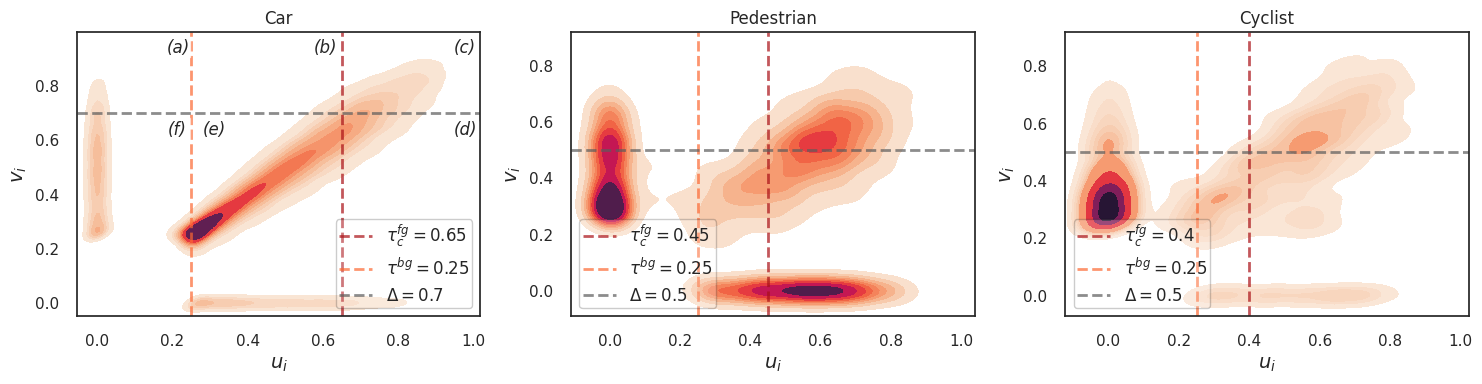

In [18]:
def get_kde_plot(df, class_name, ax, epoch_num=10):
    class_to_num = {'Car': 1, 'Pedestrian': 2, 'Cyclist': 3}
    pl_thresh = {'FG':{'Car': 0.65, 'Pedestrian': 0.45, 'Cyclist': 0.40}, 'BG': 0.25}
    gt_thresh = {'FG':{'Car': 0.70, 'Pedestrian': 0.50, 'Cyclist': 0.50}, 'BG': 0.25}

    class_num = class_to_num[class_name]
    class_mask = (torch.Tensor(df['class_labels'])).int() == class_num
    start_iter = (1439-(24*epoch_num)) if epoch_num != None else 0

    epoch_mask = torch.Tensor(df['iteration']).int() > start_iter 
    ignore_bg_mask = ~((torch.Tensor(df['iou_roi_pl']) < pl_thresh['BG']) & (torch.Tensor(df['iou_roi_gt']) < gt_thresh['BG']))
    valid_mask = class_mask & epoch_mask & ignore_bg_mask
 
    valid_df = pd.DataFrame({'iou_roi_pl': torch.Tensor(df['iou_roi_pl'])[valid_mask], 
                            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
                            'weights': torch.Tensor(df['weights'])[valid_mask],
                            'pred_scores': torch.Tensor(df['pred_scores'])[valid_mask],
                            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]})
    valid_df['class_labels'] = valid_df['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})
# add title to kde plot
    ax.set_title(class_name, fontsize=12)
    sns.kdeplot(x=valid_df.iou_roi_pl, y=valid_df.iou_roi_gt, cmap=cmap, palette="rocket_r", shade=True, bw_adjust=.5, ax=ax)

    ax.axvline(x=pl_thresh['FG'][class_name], ymin=0, ymax=1, linestyle='--', color=sns.color_palette("Reds")[-1], label="$\\tau^{fg}_{c}=var$".replace('var', str(pl_thresh['FG'][class_name])), alpha = 0.7, lw=2)
    ax.axvline(x=pl_thresh['BG'], ymin=0, ymax=1, linestyle='--', color=sns.color_palette('YlOrRd')[-3], label="$\\tau^{bg}=var$".replace('var', str(pl_thresh['BG'])), alpha = 0.7, lw=2)
    ax.axhline(y=gt_thresh['FG'][class_name], xmin=0, xmax=1, linestyle='--', color=sns.color_palette("Greys")[-2], label="$\\Delta=var$".replace('var', str(gt_thresh['FG'][class_name])), alpha = 0.7, lw=2)
    # ax.axhline(y=gt_thresh['BG'], xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau_{bg}=var$".replace('var', str(gt_thresh['BG'])), alpha = 0.7, lw=2)
    ax.set_xlabel('$u_{i}$', fontsize=14)
    ax.set_ylabel('$v_{i}$', fontsize=14)
    if class_name=='Car':
        legend_loc = "lower right"
    else:
        legend_loc = "lower left"
    legend = ax.legend(frameon=True, fontsize=12, loc=legend_loc, borderpad=0.2, framealpha = 0.2)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')
    
    if class_name=='Car':
        edge_color = 'white'
        ax.text(0.184, 0.92, '(a)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.575, 0.92, '(b)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.95, 0.92, '(c)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.95, 0.62, '(d)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.28, 0.62, '(e)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2, 'edgecolor': edge_color})
        ax.text(0.188, 0.62, '(f)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2, 'edgecolor': edge_color})


fig, axes = plt.subplots(1, 3, figsize=(15, 4))

get_kde_plot(df, 'Car', epoch_num=10, ax=axes[0]) # 0.5
get_kde_plot(df, 'Pedestrian', epoch_num=10, ax=axes[1]) #14
get_kde_plot(df, 'Cyclist', epoch_num=10, ax=axes[2]) #24

fig.tight_layout()
fig.savefig(fname="ious_kde.pdf", transparent=False, bbox_inches='tight')
plt.show()